# 0. Setup and Imports

In [1]:
import numpy as np
import pandas as pd 
import copy

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.pyplot as plt

2024-07-23 11:18:05.628851: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 11:18:05.631497: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 11:18:05.673145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 11:18:05.673184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 11:18:05.674244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# 1. Read the data

This is from Keras

In [2]:
m_train = 50000
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train, x_valid = x_train_full[:m_train]/255.0,  x_train_full[m_train:]/255.0
y_train, y_valid = y_train_full[:m_train],  y_train_full[m_train:] 
x_test = x_test/255.0

Let's check the train and test set shapes

In [3]:
# train set
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
# validation set 
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
# test set 
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (50000, 28, 28)
y_train shape: (50000,)
x_valid shape: (10000, 28, 28)
y_valid shape: (10000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


And let's look at the counts in each set:

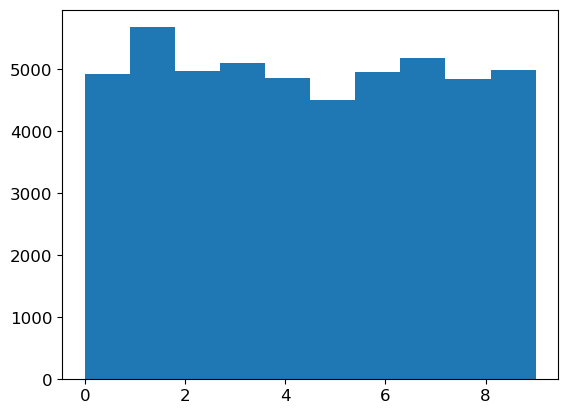

In [4]:
plt.hist(y_train)
plt.show()

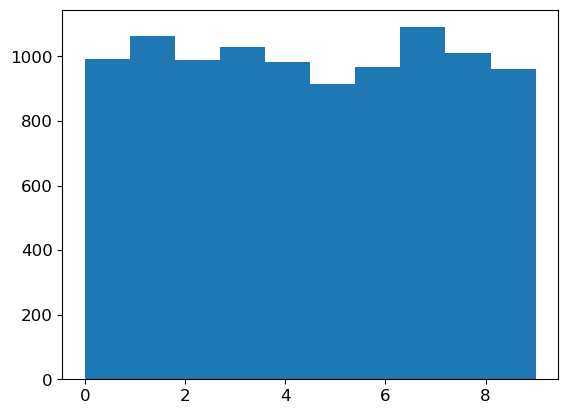

In [5]:
plt.hist(y_valid)
plt.show()

In [6]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts/np.sum(counts))).T)

[[0.     0.098 ]
 [1.     0.1135]
 [2.     0.1032]
 [3.     0.101 ]
 [4.     0.0982]
 [5.     0.0892]
 [6.     0.0958]
 [7.     0.1028]
 [8.     0.0974]
 [9.     0.1009]]


Let's look at a random case:

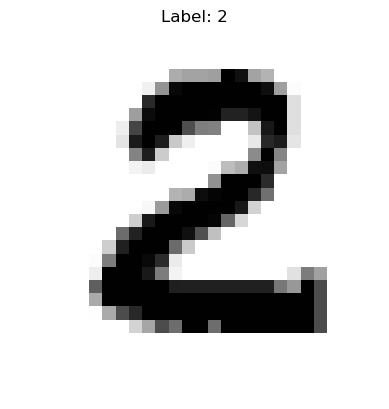

In [7]:
_test_n = np.random.randint(low= 0, high=50000)
plt.imshow(255*x_train[_test_n], cmap="binary")
plt.title(f"Label: {y_train[_test_n]}")
plt.axis('off')
plt.show()

# 2. Models 

We follow chapter 10 and create multiple models, try to fine tune them.

## 2.1. model 1

This is a simple sequential model with 2 Hidden layers:

In [8]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model_1 = keras.models.Sequential(
    [
        # 0. input layer: A flatten layer with the shape 28*28. 
        keras.layers.Flatten(
            input_shape = [28,28],
            name = "flatten_input"
        ),
        # 
        # 1. First Hidden layer: 
        keras.layers.Dense(
            units = 300,
            activation = 'relu',
            name = "h1"
        ),
        #
        # 2. Second Hiiden layer
        keras.layers.Dense(
            units = 100,
            activation = 'relu',
            name = 'h2'
        ),
        #
        # 3. output layer with 10 units corresponding to 10 digits. 
        # We use 'softmax' activation function, to get probabilities. 
        keras.layers.Dense(
            units = 10,
            activation = 'softmax',
            name = 'output' 
        )
    ]
)
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_input (Flatten)     (None, 784)               0         
                                                                 
 h1 (Dense)                  (None, 300)               235500    
                                                                 
 h2 (Dense)                  (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


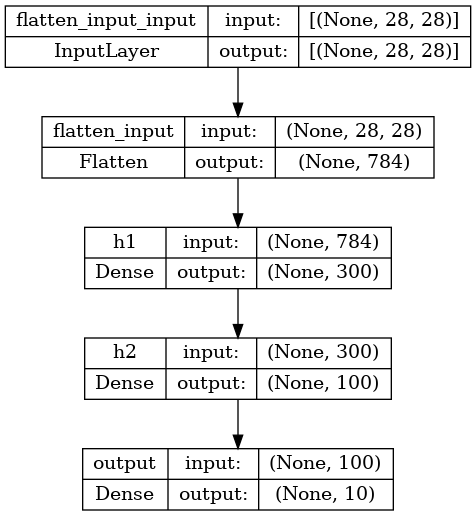

In [9]:
keras.utils.plot_model(model_1, "model_1.png", show_shapes=True)

In [11]:
histories_lr = {}

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

learning_rate_list = np.logspace(
    start = -4,
    stop = 1,
    num = 6,
    endpoint = True,
    base= 10
)

counter = 0

for lr in learning_rate_list:
    print(f" lr is {lr}")
    # copy the base model
    lr_model = keras.models.Sequential(
        [
            # 0. input layer: A flatten layer with the shape 28*28. 
            keras.layers.Flatten(
                input_shape = [28,28],
                name = "flatten_input"
            ),
            # 
            # 1. First Hidden layer: 
            keras.layers.Dense(
                units = 300,
                activation = 'relu',
                name = "h1"
            ),
            #
            # 2. Second Hiiden layer
            keras.layers.Dense(
                units = 100,
                activation = 'relu',
                name = 'h2'
            ),
            #
            # 3. output layer with 10 units corresponding to 10 digits. 
            # We use 'softmax' activation function, to get probabilities. 
            keras.layers.Dense(
                units = 10,
                activation = 'softmax',
                name = 'output' 
            )
        ]
    )
    # Compile the model 
    lr_model.compile(
        # we could write loss = 'sparse_categorical_crossentropy'
        loss = keras.losses.SparseCategoricalCrossentropy(), 
        #
        # we could write optimizer = 'sgd'
        optimizer = keras.optimizers.SGD(learning_rate = float(lr)),
        #
        #
        metrics = [keras.metrics.SparseCategoricalAccuracy()]
    )
    # fit
    lr_model_history = lr_model.fit(
        x_train,
        y_train,
        epochs = 10,
        validation_data = (x_valid, y_valid)
    )

    histories_lr[str(counter)] = { 
        'lr' : lr,
        'history' : lr_model_history.history
    }
    counter +=1 

 lr is 0.0001
Epoch 1/10
1563/1563 [==============================] - 15s 9ms/step - loss: 2.2905 - sparse_categorical_accuracy: 0.1090 - val_loss: 2.2239 - val_sparse_categorical_accuracy: 0.1694
Epoch 2/10
1563/1563 [==============================] - 15s 10ms/step - loss: 2.1732 - sparse_categorical_accuracy: 0.2500 - val_loss: 2.1125 - val_sparse_categorical_accuracy: 0.3709
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.0682 - sparse_categorical_accuracy: 0.4391 - val_loss: 2.0073 - val_sparse_categorical_accuracy: 0.5357
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.9657 - sparse_categorical_accuracy: 0.5513 - val_loss: 1.9019 - val_sparse_categorical_accuracy: 0.6104
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8620 - sparse_categorical_accuracy: 0.6121 - val_loss: 1.7942 - val_sparse_categorical_accuracy: 0.6591
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step -

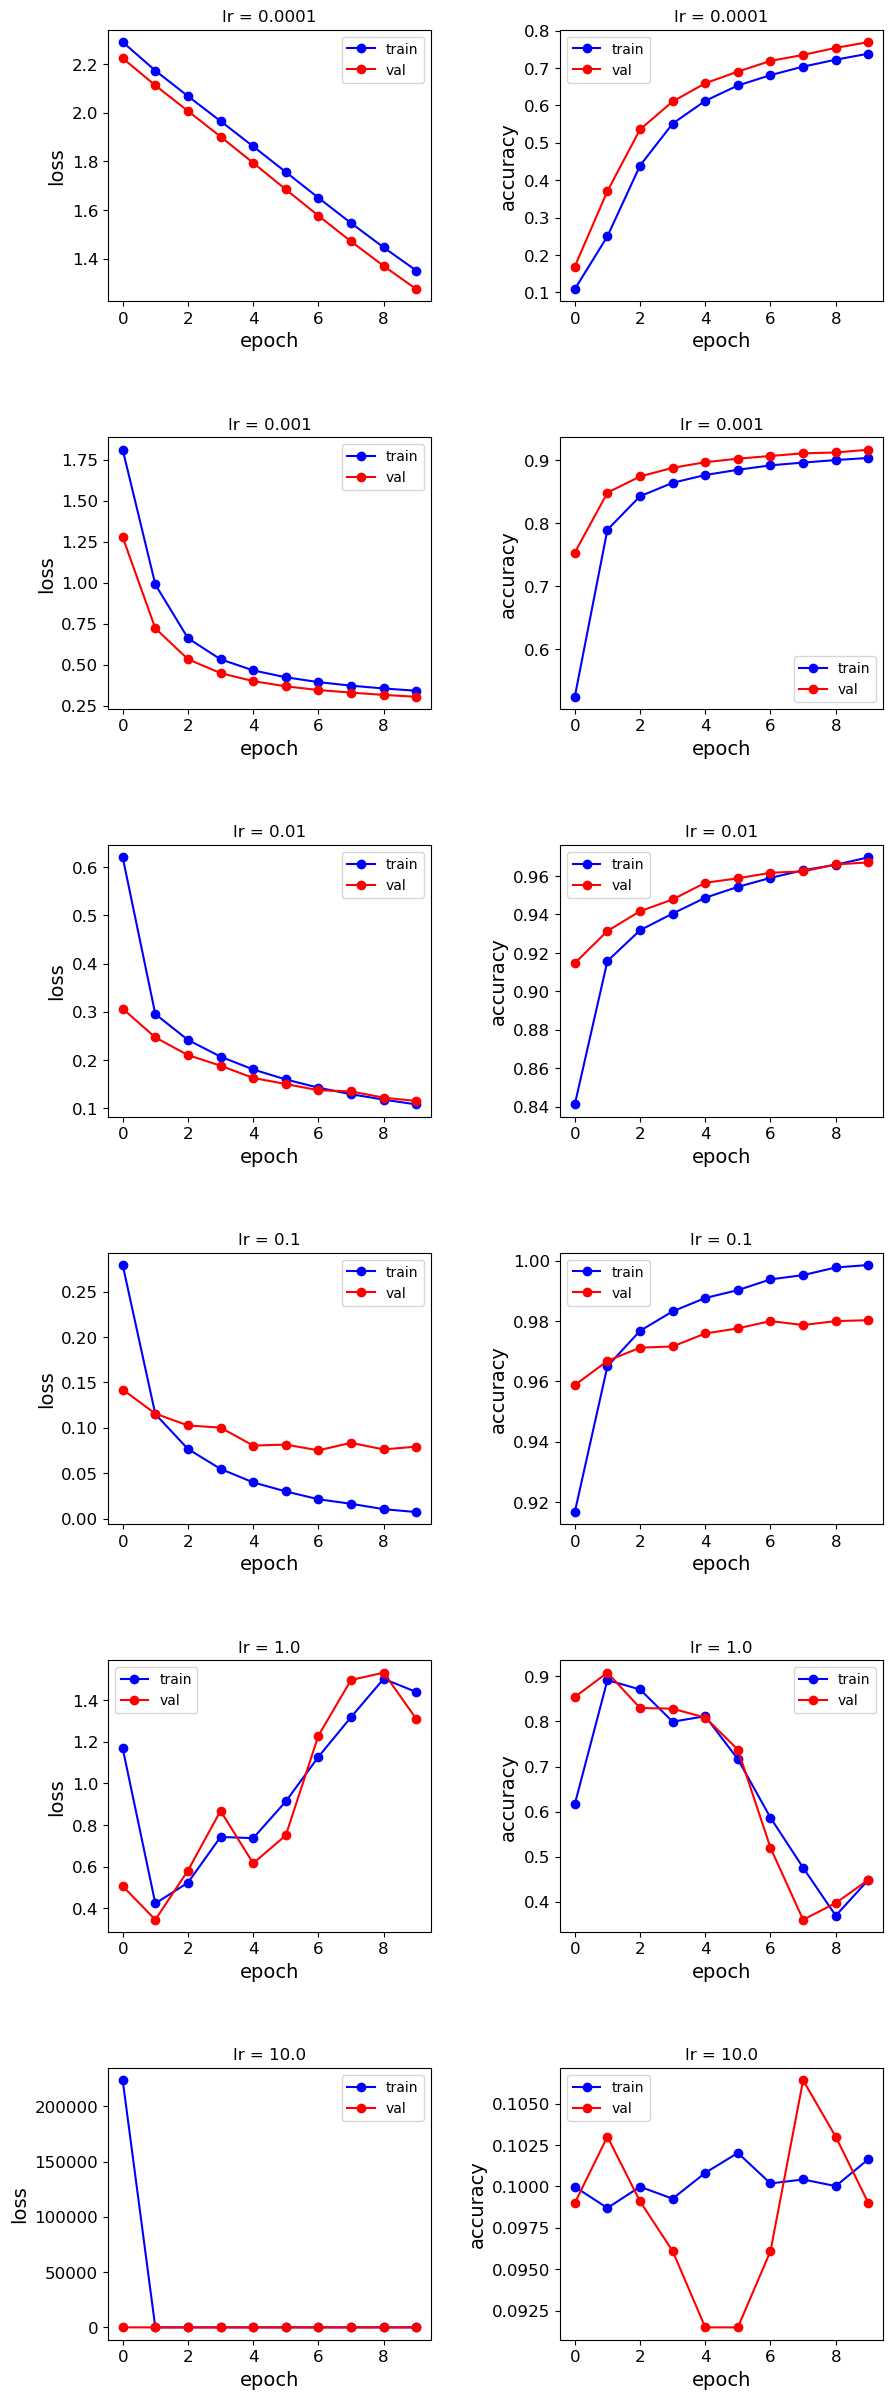

In [12]:
n_rows = counter
n_cols = 2
plt.figure(figsize=(n_cols * 5, n_rows * 5))
for row in range(n_rows):
    index = n_cols * row 
    plt.subplot(n_rows, n_cols, index + 1)
    plt.plot(histories_lr[str(row)]['history']['loss'], 'bo-', label = 'train')
    plt.plot(histories_lr[str(row)]['history']['val_loss'], 'ro-', label = 'val')
    plt.legend()
    plt.title(f"lr = {histories_lr[str(row)]['lr']}")
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.subplot(n_rows, n_cols, index + 2)
    plt.plot(histories_lr[str(row)]['history']['sparse_categorical_accuracy'], 'bo-', label = 'train')
    plt.plot(histories_lr[str(row)]['history']['val_sparse_categorical_accuracy'], 'ro-',  label = 'val')
    plt.legend()
    plt.title(f"lr = {histories_lr[str(row)]['lr']}")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()

Ok, it does diverge for `learning_rate = 10`. So let's try `learning_rate = 0.5` as it was suggested in the book: 

In [13]:
m1 = keras.models.Sequential(
        [
            # 0. input layer: A flatten layer with the shape 28*28. 
            keras.layers.Flatten(
                input_shape = [28,28],
                name = "flatten_input"
            ),
            # 
            # 1. First Hidden layer: 
            keras.layers.Dense(
                units = 300,
                activation = 'relu',
                name = "h1"
            ),
            #
            # 2. Second Hiiden layer
            keras.layers.Dense(
                units = 100,
                activation = 'relu',
                name = 'h2'
            ),
            #
            # 3. output layer with 10 units corresponding to 10 digits. 
            # We use 'softmax' activation function, to get probabilities. 
            keras.layers.Dense(
                units = 10,
                activation = 'softmax',
                name = 'output' 
            )
        ]
    )
# Compile the model 
m1.compile(
    # we could write loss = 'sparse_categorical_crossentropy'
    loss = keras.losses.SparseCategoricalCrossentropy(), 
    #
    # we could write optimizer = 'sgd'
    optimizer = keras.optimizers.SGD(learning_rate = 0.25),
    #
    #
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
# fit
m1_history = m1.fit(
    x_train,
    y_train,
    epochs = 100,
    validation_data = (x_valid, y_valid),
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience = 20,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100
1563/1563 [==============================] - 15s 10ms/step - loss: 0.2404 - sparse_categorical_accuracy: 0.9263 - val_loss: 0.1180 - val_sparse_categorical_accuracy: 0.9651
Epoch 2/100
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0996 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.1456 - val_sparse_categorical_accuracy: 0.9542
Epoch 3/100
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0678 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.0833 - val_sparse_categorical_accuracy: 0.9757
Epoch 4/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0460 - sparse_categorical_accuracy: 0.9856 - val_loss: 0.0781 - val_sparse_categorical_accuracy: 0.9793
Epoch 5/100
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0355 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.0931 - val_sparse_categorical_accuracy: 0.9750
Epoch 6/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0

Text(0.5, 0, 'epoch')

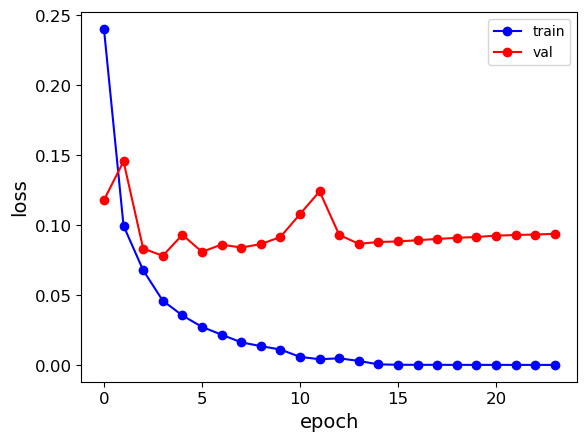

In [14]:
plt.plot(m1.history.history['loss'], 'bo-', label = 'train')
plt.plot(m1.history.history['val_loss'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

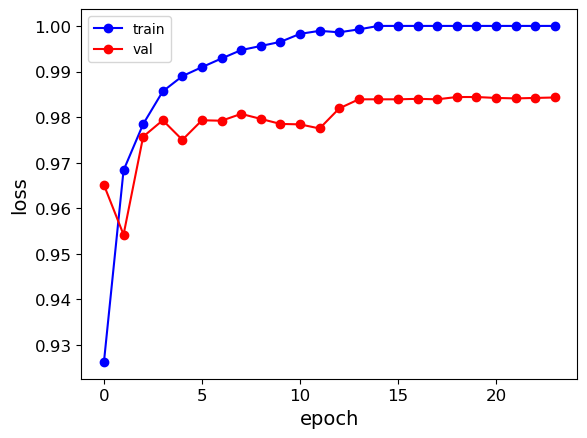

In [15]:
plt.plot(m1.history.history['sparse_categorical_accuracy'], 'bo-', label = 'train')
plt.plot(m1.history.history['val_sparse_categorical_accuracy'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

We see that, the training loss is almost zero, `~ 1e-4` and its accuracy is `1`. \
There is, however, a gap both in the loss and in the accuracy. \
So this needs some fine-tuning since it is overfitting. Let's try a bit smaller NN. 

## 2.2. Model 2

In [61]:
histories_lr = {}

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

learning_rate_list = np.logspace(
    start = -4,
    stop = 0,
    num = 12,
    endpoint = True,
    base= 10
)

counter = 0

for lr in learning_rate_list:
    print(f" lr is {lr}")
    # copy the base model
    lr_model = keras.models.Sequential(
        [
            # 0. input layer: A flatten layer with the shape 28*28. 
            keras.layers.Flatten(
                input_shape = [28,28],
                name = "flatten_input"
            ),
            # 
            # 1. First Hidden layer: 
            keras.layers.Dense(
                units = 100,
                activation = 'relu',
                name = "h1"
            ),
            #
            # 2. Second Hiiden layer
            keras.layers.Dense(
                units = 50,
                activation = 'relu',
                name = 'h2'
            ),
            #
            # 3. output layer with 10 units corresponding to 10 digits. 
            # We use 'softmax' activation function, to get probabilities. 
            keras.layers.Dense(
                units = 10,
                activation = 'softmax',
                name = 'output' 
            )
        ]
    )
    # Compile the model 
    lr_model.compile(
        # we could write loss = 'sparse_categorical_crossentropy'
        loss = keras.losses.SparseCategoricalCrossentropy(), 
        #
        # we could write optimizer = 'sgd'
        optimizer = keras.optimizers.SGD(learning_rate = float(lr)),
        #
        #
        metrics = [keras.metrics.SparseCategoricalAccuracy()]
    )
    # fit
    lr_model_history = lr_model.fit(
        x_train,
        y_train,
        epochs = 10,
        validation_data = (x_valid, y_valid)
    )

    histories_lr[str(counter)] = { 
        'lr' : lr,
        'history' : lr_model_history.history
    }
    counter +=1 

 lr is 0.0001
Epoch 1/10
1563/1563 [==============================] - 3s 2ms/step - loss: 2.3201 - sparse_categorical_accuracy: 0.0774 - val_loss: 2.2779 - val_sparse_categorical_accuracy: 0.1186
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 2.2459 - sparse_categorical_accuracy: 0.1546 - val_loss: 2.2069 - val_sparse_categorical_accuracy: 0.2123
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 2.1785 - sparse_categorical_accuracy: 0.2429 - val_loss: 2.1381 - val_sparse_categorical_accuracy: 0.2987
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 2.1105 - sparse_categorical_accuracy: 0.3235 - val_loss: 2.0668 - val_sparse_categorical_accuracy: 0.3747
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 2.0390 - sparse_categorical_accuracy: 0.3934 - val_loss: 1.9912 - val_sparse_categorical_accuracy: 0.4444
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 

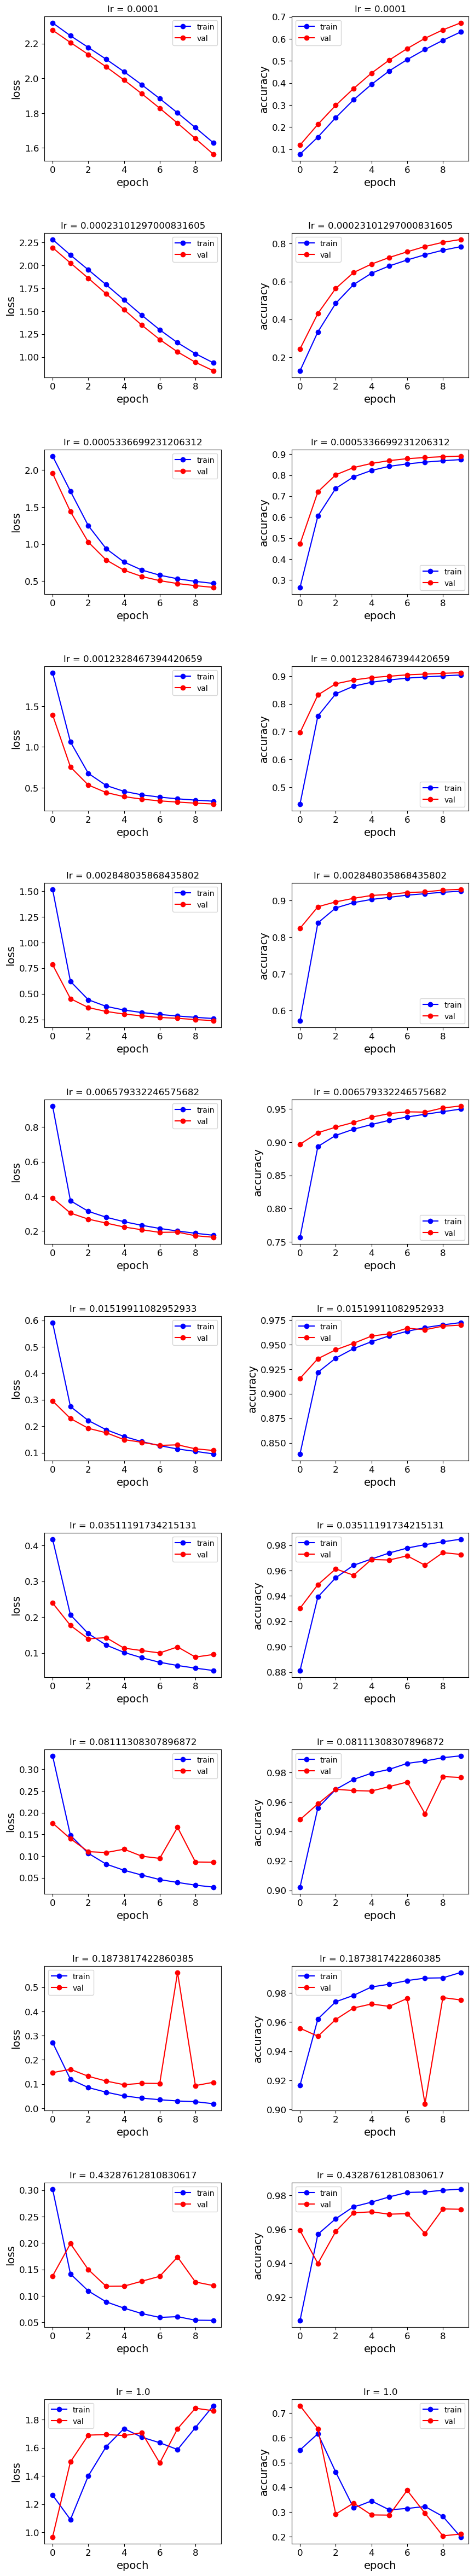

In [62]:
n_rows = counter
n_cols = 2
plt.figure(figsize=(n_cols * 5, n_rows * 5))
for row in range(n_rows):
    index = n_cols * row 
    plt.subplot(n_rows, n_cols, index + 1)
    plt.plot(histories_lr[str(row)]['history']['loss'], 'bo-', label = 'train')
    plt.plot(histories_lr[str(row)]['history']['val_loss'], 'ro-', label = 'val')
    plt.legend()
    plt.title(f"lr = {histories_lr[str(row)]['lr']}")
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.subplot(n_rows, n_cols, index + 2)
    plt.plot(histories_lr[str(row)]['history']['sparse_categorical_accuracy'], 'bo-', label = 'train')
    plt.plot(histories_lr[str(row)]['history']['val_sparse_categorical_accuracy'], 'ro-',  label = 'val')
    plt.legend()
    plt.title(f"lr = {histories_lr[str(row)]['lr']}")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()

In [72]:
m2 = keras.models.Sequential(
        [
            # 0. input layer: A flatten layer with the shape 28*28. 
            keras.layers.Flatten(
                input_shape = [28,28],
                name = "flatten_input"
            ),
            # 
            # 1. First Hidden layer: 
            keras.layers.Dense(
                units = 100,
                activation = 'relu',
                name = "h1"
            ),
            #
            # 2. Second Hiiden layer
            keras.layers.Dense(
                units = 50,
                activation = 'relu',
                name = 'h2'
            ),
            #
            # 3. output layer with 10 units corresponding to 10 digits. 
            # We use 'softmax' activation function, to get probabilities. 
            keras.layers.Dense(
                units = 10,
                activation = 'softmax',
                name = 'output' 
            )
        ]
    )
# Compile the model 
m2.compile(
    # we could write loss = 'sparse_categorical_crossentropy'
    loss = keras.losses.SparseCategoricalCrossentropy(), 
    #
    # we could write optimizer = 'sgd'
    optimizer = keras.optimizers.SGD(learning_rate = 0.05),
    #
    #
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
# fit
m2_history = m2.fit(
    x_train,
    y_train,
    epochs = 60,
    validation_data = (x_valid, y_valid),
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience = 20,
            restore_best_weights = True
        )
    ]
)

Epoch 1/60
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3762 - sparse_categorical_accuracy: 0.8907 - val_loss: 0.2018 - val_sparse_categorical_accuracy: 0.9402
Epoch 2/60
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1775 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.1619 - val_sparse_categorical_accuracy: 0.9538
Epoch 3/60
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1286 - sparse_categorical_accuracy: 0.9612 - val_loss: 0.1252 - val_sparse_categorical_accuracy: 0.9637
Epoch 4/60
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9702 - val_loss: 0.1196 - val_sparse_categorical_accuracy: 0.9659
Epoch 5/60
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0819 - sparse_categorical_accuracy: 0.9749 - val_loss: 0.1022 - val_sparse_categorical_accuracy: 0.9705
Epoch 6/60
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0695 - spars

In [73]:
m2_history.history

{'loss': [0.3762190639972687,
  0.17752425372600555,
  0.12860217690467834,
  0.10112602263689041,
  0.08194240927696228,
  0.0695241242647171,
  0.05945427715778351,
  0.05054861679673195,
  0.04458390176296234,
  0.03781595081090927,
  0.03308236226439476,
  0.029027648270130157,
  0.024555116891860962,
  0.022055258974432945,
  0.018175974488258362,
  0.015065668150782585,
  0.012516127899289131,
  0.010310599580407143,
  0.008675962686538696,
  0.007697599474340677,
  0.0065543255768716335,
  0.0054611568339169025,
  0.004586262162774801,
  0.004153952468186617,
  0.003572298213839531,
  0.0030740322545170784,
  0.0024190472904592752,
  0.0022250076290220022,
  0.0018949405057355762],
 'sparse_categorical_accuracy': [0.8906800150871277,
  0.9480999708175659,
  0.9612399935722351,
  0.9702200293540955,
  0.9749199748039246,
  0.9794800281524658,
  0.9825999736785889,
  0.9850000143051147,
  0.9864599704742432,
  0.989080011844635,
  0.9905999898910522,
  0.9916200041770935,
  0.9929

Text(0.5, 0, 'epoch')

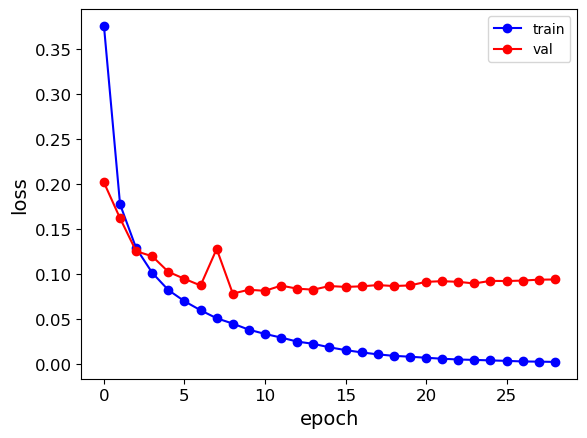

In [74]:
plt.plot(m2.history.history['loss'], 'bo-', label = 'train')
plt.plot(m2.history.history['val_loss'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

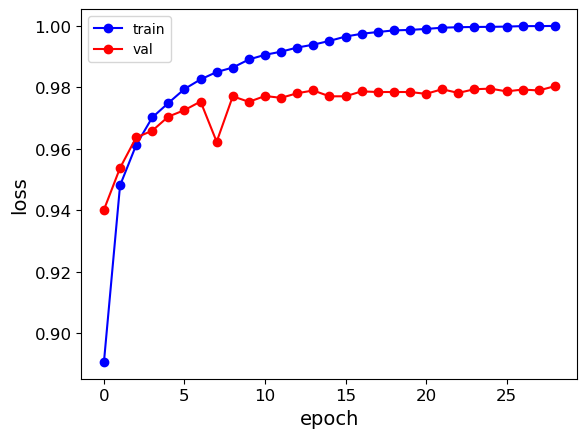

In [75]:
plt.plot(m2.history.history['sparse_categorical_accuracy'], 'bo-', label = 'train')
plt.plot(m2.history.history['val_sparse_categorical_accuracy'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

I played with the number of neurons and we still suffer from overfitting, I believe. So other moethods are needed. 